# Transfer Learning using Yammet [link](https://www.tensorflow.org/tutorials/audio/transfer_learning_audio)

In [1]:
import os
import glob # for geting filenames

from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.io import wavfile # using wavfile.read to read the wav file
from scipy import signal

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_io as tfio

# Set the seed value for experiment reproducibility.
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

print('GPU: ','available' if tf.config.list_physical_devices('GPU') else 'not avaiable') 

2023-03-09 22:06:25.914155: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-09 22:06:26.997505: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.7/lib64:
2023-03-09 22:06:26.997629: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.7/lib64:
2023-03-09 22:06:26.997641: W tensorflow/compiler/tf2tensorrt/utils/py_uti

GPU:  available


2023-03-09 22:06:27.835762: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-09 22:06:27.948075: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-09 22:06:27.948912: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [2]:
yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'
yamnet_model = hub.load(yamnet_model_handle)

2023-03-09 22:06:31.151438: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-09 22:06:31.152266: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-09 22:06:31.152740: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-09 22:06:31.153108: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least on

In [3]:
# reading the data
metadata_path = './9-audio-age-classification/'
base_data_path = f'{metadata_path}/dataset/waves/multiple_sentences/'

pd_data = pd.read_excel(f'{metadata_path}BVC_Age.xlsx')
pd_data.head()
# for index, raw in pd_data.head().iterrows():
    # print(raw['New_ID'])

,New_ID,Age
0,4001,19
1,4002,23
2,4003,18
3,4004,23
4,4005,17


In [4]:
pd_data[pd_data['New_ID']==4001]['Age'].to_numpy()[0]

19

In [5]:
glob.glob(f'{base_data_path}*4530*')

['./9-audio-age-classification//dataset/waves/multiple_sentences/S_01_4530_VV2.wav',
 './9-audio-age-classification//dataset/waves/multiple_sentences/S_01_4530_VV3.wav',
 './9-audio-age-classification//dataset/waves/multiple_sentences/S_01_4530_VE5.wav',
 './9-audio-age-classification//dataset/waves/multiple_sentences/S_01_4530_VE2.wav',
 './9-audio-age-classification//dataset/waves/multiple_sentences/S_01_4530_VV5.wav',
 './9-audio-age-classification//dataset/waves/multiple_sentences/S_01_4530_VV4.wav',
 './9-audio-age-classification//dataset/waves/multiple_sentences/S_01_4530_VV1.wav',
 './9-audio-age-classification//dataset/waves/multiple_sentences/S_01_4530_VE4.wav',
 './9-audio-age-classification//dataset/waves/multiple_sentences/S_01_4530_VE1.wav',
 './9-audio-age-classification//dataset/waves/multiple_sentences/S_01_4530_VE3.wav']

In [21]:
def play(x, y):
    x = x +1
    return x/y

def test_play():
    x=[1, 2, 3, 4]
    y=[1, 1, 0, 1]
    for i, j in zip(x, y):
        try:
            out = play(i, j)
        except:
            continue
            
        print(out)
        
test_play()

2.0
3.0
5.0


In [28]:
#getting audio files
# Utility functions for loading audio files and making sure the sample rate is correct.


@tf.function
def load_wav_16k_mono(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(
            file_contents,
            desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64) # like c type casting
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

       
# @tf.function
def load_whole_dataset():
    for index, raw in pd_data.iterrows():
        wav_code = raw['New_ID']
        files_list = glob.glob(f'{base_data_path}*{wav_code}*')
        for file in files_list:
            try:
                audio_sample = load_wav_16k_mono(file)
            except:
                continue
                
            yield audio_sample, raw['Age']



In [29]:
# using scipy wavfile.read

# @tf.function
def load_wav_16k_mono_scipy(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    """ docs: https://docs.scipy.org/doc/scipy/reference/generated/scipy.io.wavfile.read.html"""
    sample_rate, wav = wavfile.read(filename)
    wav = tf.constant(wav)
    wav = tf.cast(tf.transpose(wav)[0], dtype=tf.float32)/32767.0 # taking the first cahannel and normalizing it
    new_rate = int(wav.shape[0] * 16000 / sample_rate)
    wav = signal.resample(wav.numpy(), new_rate)
    return tf.constant(wav)

       
# @tf.function
def load_whole_dataset_scipy():
    for index, raw in pd_data.iterrows():
        wav_code = raw['New_ID']
        files_list = glob.glob(f'{base_data_path}*{wav_code}*')
        for file in files_list:
            # print(file)
            yield load_wav_16k_mono_scipy(file), raw['Age']

file1 ='./9-audio-age-classification//dataset/waves/multiple_sentences/S_01_4006_VE.wav' 
file2 ='./9-audio-age-classification//dataset/waves/multiple_sentences/S_01_4007_VV.wav'

wav = load_wav_16k_mono_scipy(file2)
print(tf.reduce_max(wav))
print(wav.shape)
display.Audio(wav, rate=16000)

tf.Tensor(0.14507294, shape=(), dtype=float32)
(39919,)


/tmp/ipykernel_25916/3608839740.py:7: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sample_rate, wav = wavfile.read(filename)


In [30]:
#./9-audio-age-classification//dataset/waves/multiple_sentences/S_01_4289_VV.wav adpdm foram
# for wav, age in load_whole_dataset_scipy():
    # print()

In [31]:
# loadin the dataset
main_ds = tf.data.Dataset.from_generator(
     load_whole_dataset,
     output_signature=(
         tf.TensorSpec(shape=(None, ), dtype=tf.float32),
         tf.TensorSpec(shape=(), dtype=tf.float32)))
main_ds.element_spec

(TensorSpec(shape=(None,), dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.float32, name=None))

In [33]:
wav, age = next(iter(main_ds.take(1)))
print(wav.shape)
print(age)
display.Audio(wav, rate=16000)

(17793,)
tf.Tensor(19.0, shape=(), dtype=float32)


In [34]:
# applying yamet embedding 
# it generate embedding every (window size) so for a single input it will produce n x 1024

# applies the embedding extraction model to a wav data
def extract_embedding(wav_data, label):
    ''' run YAMNet to extract embedding from the wav data '''
    scores, embeddings, spectrogram = yamnet_model(wav_data)
    num_embeddings = tf.shape(embeddings)[0]
    # return (embeddings,
              # tf.repeat(label, num_embeddings))
    ''' averaging embeddings '''
    return (tf.math.reduce_mean(embeddings, axis=0), label)

# extract embedding
# main_ds = main_ds.map(extract_embedding).unbatch()
main_ds = main_ds.map(extract_embedding)
main_ds.element_spec

(TensorSpec(shape=(1024,), dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.float32, name=None))

In [35]:
emed, age = next(iter(main_ds.take(1)))
print(emed.shape)
print(age)

(1024,)
tf.Tensor(19.0, shape=(), dtype=float32)


In [36]:
# spliting in train and test
BATCH_SIZE = 32
NUM_SHARDS = 4
cached_ds = main_ds.cache()
test_ds = cached_ds.shard(num_shards=NUM_SHARDS, index=0)

train_ds = cached_ds.shard(num_shards=NUM_SHARDS, index=1)
for i in range(NUM_SHARDS-2):
    train_ds = train_ds.concatenate(cached_ds.shard(num_shards=5, index=i+2))
    
val_ds = test_ds.shard(num_shards=2, index=0) # 10% val
test_ds = test_ds.shard(num_shards=2, index=1)# 10% test


train_ds = train_ds.cache().shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.cache().batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


In [ ]:
embed, age = next(iter(train_ds.take(1)))
print(embed.shape)

2023-03-09 22:53:28.667872: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 9 of 1000


2023-03-09 22:53:30.580827: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at decode_wav_op.cc:52 : INVALID_ARGUMENT: Data too short when trying to read string
2023-03-09 22:53:30.584780: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at decode_wav_op.cc:52 : INVALID_ARGUMENT: Data too short when trying to read string


2023-03-09 22:53:30.776849: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at decode_wav_op.cc:52 : INVALID_ARGUMENT: Data too short when trying to read string
2023-03-09 22:53:30.782350: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at decode_wav_op.cc:52 : INVALID_ARGUMENT: Data too short when trying to read string


2023-03-09 22:53:38.000731: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 15 of 1000


2023-03-09 22:53:48.625197: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 22 of 1000


2023-03-09 22:53:57.146723: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 28 of 1000


In [30]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (1024), dtype=tf.float32),
    tf.keras.layers.Dense(256, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Normalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    tf.keras.layers.Normalization(),
    # tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1,activation='relu')
])
model.compile(loss=tf.keras.losses.MeanSquaredError(),
              optimizer = tf.keras.optimizers.Adam(),
              metrics=['mean_squared_error'])

callback = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                            patience=3, # weight for 3 ecpochs
                                            restore_best_weights=True)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               262400    
                                                                 
 normalization (Normalizatio  (None, 256)              513       
 n)                                                              
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 normalization_1 (Normalizat  (None, 128)              257       
 ion)                                                            
                                                                 
 dense_2 (Dense)             (None, 1)                 1

In [31]:
history = model.fit(
    train_ds,
    epochs=100,
    validation_data = val_ds,
    callbacks=callback,
    verbose =2)

Epoch 1/100


/tmp/ipykernel_3944/3608839740.py:7: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sample_rate, wav = wavfile.read(filename)
2023-02-28 00:22:33.067907: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 221 of 1000
2023-02-28 00:22:43.078423: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 446 of 1000
2023-02-28 00:22:53.012520: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 674 of 1000
2023-02-28 00:23:03.019859: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 895 of 1000
2023-02-28 00:23:07.942489: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.
2023-02-28 00:23:10.114548: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x2a354260 initialized for platform CUDA (this does not guaran

InvalidArgumentError: Graph execution error:

2 root error(s) found.
  (0) INVALID_ARGUMENT:  ValueError: Unknown wave file format: ADPCM. Supported formats: PCM, IEEE_FLOAT
Traceback (most recent call last):

  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/ops/script_ops.py", line 271, in __call__
    ret = func(*args)

  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/autograph/impl/api.py", line 642, in wrapper
    return func(*args, **kwargs)

  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/data/ops/dataset_ops.py", line 1039, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "/tmp/ipykernel_3944/3608839740.py", line 22, in load_whole_dataset_scipy
    yield load_wav_16k_mono_scipy(file), raw['Age']

  File "/tmp/ipykernel_3944/3608839740.py", line 7, in load_wav_16k_mono_scipy
    sample_rate, wav = wavfile.read(filename)

  File "/usr/local/lib/python3.8/dist-packages/scipy/io/wavfile.py", line 679, in read
    fmt_chunk = _read_fmt_chunk(fid, is_big_endian)

  File "/usr/local/lib/python3.8/dist-packages/scipy/io/wavfile.py", line 378, in _read_fmt_chunk
    _raise_bad_format(format_tag)

  File "/usr/local/lib/python3.8/dist-packages/scipy/io/wavfile.py", line 315, in _raise_bad_format
    raise ValueError(f"Unknown wave file format: {format_name}. Supported "

ValueError: Unknown wave file format: ADPCM. Supported formats: PCM, IEEE_FLOAT


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]]
	 [[IteratorGetNext/_4]]
  (1) INVALID_ARGUMENT:  ValueError: Unknown wave file format: ADPCM. Supported formats: PCM, IEEE_FLOAT
Traceback (most recent call last):

  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/ops/script_ops.py", line 271, in __call__
    ret = func(*args)

  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/autograph/impl/api.py", line 642, in wrapper
    return func(*args, **kwargs)

  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/data/ops/dataset_ops.py", line 1039, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "/tmp/ipykernel_3944/3608839740.py", line 22, in load_whole_dataset_scipy
    yield load_wav_16k_mono_scipy(file), raw['Age']

  File "/tmp/ipykernel_3944/3608839740.py", line 7, in load_wav_16k_mono_scipy
    sample_rate, wav = wavfile.read(filename)

  File "/usr/local/lib/python3.8/dist-packages/scipy/io/wavfile.py", line 679, in read
    fmt_chunk = _read_fmt_chunk(fid, is_big_endian)

  File "/usr/local/lib/python3.8/dist-packages/scipy/io/wavfile.py", line 378, in _read_fmt_chunk
    _raise_bad_format(format_tag)

  File "/usr/local/lib/python3.8/dist-packages/scipy/io/wavfile.py", line 315, in _raise_bad_format
    raise ValueError(f"Unknown wave file format: {format_name}. Supported "

ValueError: Unknown wave file format: ADPCM. Supported formats: PCM, IEEE_FLOAT


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]]
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_31523]

In [76]:
# test the model 
loss= model.evaluate(test_ds, verbose=2)

1/1 - 0s - loss: 12.1510 - mean_squared_error: 11.8941 - 25ms/epoch - 25ms/step


In [77]:
embed, age = next(iter(test_ds.take(1)))
print(embed[:5].shape)
print(tf.math.reduce_mean(age[:5]))
print(tf.math.reduce_mean(model(embed[:5])))

(5, 1024)
tf.Tensor(19.0, shape=(), dtype=float32)
tf.Tensor(21.463415, shape=(), dtype=float32)


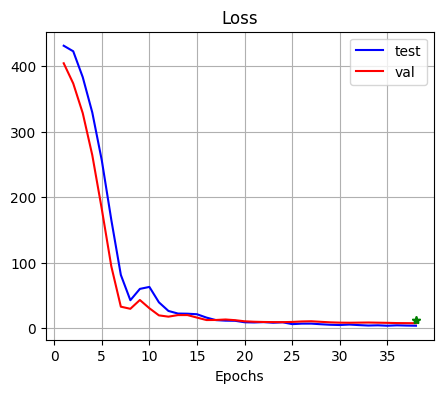

In [80]:
def plot_test_val(ax, title, test, val, test_point):
    x = np.arange(1, len(test) +1, 1)
    ax.plot(x, test, label='test', color='b')
    ax.plot(x, val, label='val', color='r')
    ax.plot([len(test)], [test_point], 'g*')
    # ax.annotate(f'test {title}={test_point:.3f}', xy=(len(test), test_point), xytext=(len(test)-1, test_point-.05))
    ax.set_xlabel('Epochs')
    ax.legend()
    ax.set_title(title)
    ax.grid()
    
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
plot_test_val(ax, 'Loss', history.history['loss'], history.history['val_loss'], loss)

plt.show()


In [117]:
def predict(model, wav_code, df, base_data_path):

    # concatenating embedding of all wav files
    files_list = glob.glob(f'{base_data_path}*{wav_code}*')
    wav_data = load_wav_16k_mono(files_list[0]) 
    _, test_ten, _ = yamnet_model(wav_data)
    for file in files_list[1:]:
        wav_data = load_wav_16k_mono(file) 
        _, embeddings, _ = yamnet_model(wav_data)
        test_ten = tf.concat([test_ten, embeddings], axis=0)
    

    predicted_age = tf.math.reduce_mean(model(test_ten))
    true_age = df[df['New_ID']==wav_code]['Age'].to_numpy()
    print(f'predicted = {predicted_age:.3f}, true age ={true_age}')
    return predicted_age.numpy()
    


    
predict(model, 4778, pd_data, base_data_path)
predict(model, 4363, pd_data, base_data_path)


        

predicted = 18.801, true age =[18]


predicted = 20.250, true age =[21]


20.25017

In [139]:
pd_test_data = pd_data.copy()
codes_list = list(pd_test_data['New_ID'])
age_list =[]
for code in codes_list[-3:]:
    age_list.append(predict(model, code, pd_data, base_data_path))

predicted = 21.009, true age =[22]


predicted = 18.576, true age =[23]


predicted = 18.176, true age =[18]


In [138]:
tf.keras.models.save_model(model, 'saved_model')

INFO:tensorflow:Assets written to: saved_model/assets


INFO:tensorflow:Assets written to: saved_model/assets
